相比于v3.0主要的改动在于函数cal_new_polygon函数，将边界条件处理干净即可。
内缩多边形时初始点入栈，最后应判断该初始点是否最终组成新的多边形。

In [23]:
# Calculating the maximum inscribed circle of an arbitrary convex polygon
# in 2D space
# input: a list of points coordinates which are the vertices of the polygon
# output: the center and radius of the maximum inscribed circle

import math
import numpy as np
import cv2
from queue import LifoQueue
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


eps = 1e-4

def max_inscribed_circle(points):
    """
    Calculate the center and radius of the maximum inscribed circle of an
    arbitrary convex polygon in 2D space
    :param points: a list of points coordinates which are the vertices of the polygon
    :return: the center and radius of the maximum inscribed circle
    """
    init_points = np.array(points)
    
    while True:
        # select a point inside the polygon
        center = center_point_inside_polygon(points)
        # calculate the min distance between the center and the polygon
        d = distance_point_polygon(center, points)
        # calculate the lines composed of vertices
        lines = cal_lines_by_points(points,d,center)
        # Calculate the line parallel to each edge in the polygon with distance d from the center
        new_points = cal_new_polygon(lines)
        # see if the lines construct a triangle
        # if yes, return the center and radius
        # if not, repeat calculating the line parallel to each edge in the new polygon
        if len(new_points) < 3:
            d = distance_point_polygon(center, init_points)
            return center, d
        elif len(new_points) == 3:
            p1 = new_points[0]
            p2 = new_points[1]
            p3 = new_points[2]
            center = cal_inscribed_center_triangle(p1, p2, p3)
            d = distance_point_polygon(center, init_points)
            return center, d
        else:
            new_points = np.array(new_points)
            points = new_points
        # repeat calculating the center until the new polygon is a triangle



def cal_lines_by_points(points,d,center):
    """
    Calculate the parameters a, b, c of the line ax+by+c=0
    :param points: a list of points coordinates which are the vertices of the
    polygon
    :return: a list of lines
    """
    lines = []
    for i in range(len(points)):
        p1 = points[i]
        p2 = points[(i + 1) % len(points)]
        a, b, c = cal_abc_from_line(p1[0],p1[1],p2[0],p2[1])
        c1= c-d * np.sqrt(a*a+b*b)
        c2= c+d * np.sqrt(a*a+b*b)
        d1 = abs(a*center[0]+b*center[1]+c1)
        d2 = abs(a*center[0]+b*center[1]+c2)
        if(d1<d2):
            c=c1
        else:
            c=c2
        lines.append([a, b, c])
    return lines


def cal_abc_from_line(x1, y1, x2, y2):
    """
    Calculate the parameters a, b, c of the line ax+by+c=0
    :param x1, y1: coordinate of the first point
    :param x2, y2: coordinate of the second point
    :return: a, b, c
    """
    a = y1 - y2
    b = x2 - x1
    c = x1 * y2 - x2 * y1
    return a, b, c
    
    
def distance_point_line(p, a, b):
    """
    Calculate the distance between point p and line segment ab
    :param p: vector point p
    :param a: vector point a
    :param b: vector point b
    :return: the distance between point p and line segment ab
    """
    pa = p - a
    ba = b - a
    h = np.dot(pa, ba) / np.dot(ba, ba)
    h = np.clip(h, 0, 1)
    return np.linalg.norm(pa - h * ba)


def distance_point_polygon(p, polygon):
    """
    Calculate the min distance between point p and polygon
    :param p: vector point p
    :param polygon: a list of points coordinates which are the vertices of the
    polygon
    :return: the min distance between point p and polygon
    """
    min_distance = math.inf
    for i in range(len(polygon)):
        a = polygon[i]
        b = polygon[(i + 1) % len(polygon)]
        distance = distance_point_line(p, a, b)
        if distance < min_distance:
            min_distance = distance
    return min_distance


def center_point_inside_polygon(polygon):
    """
    Select the center point inside the polygon
    :param polygon: a list of points coordinates which are the vertices of the
    polygon
    :return: the center point inside the polygon
    """
    # calculate the center of the polygon
    center = np.mean(polygon, axis=0)
    # select a point inside the polygon
    for i in range(len(polygon)):
        a = np.array(polygon[i])
        b = np.array(polygon[(i + 1) % len(polygon)])
        c = np.array(polygon[(i + 2) % len(polygon)])
        # calculate the angle between line segment ab and bc
        ba = a - b
        bc = c - b
        angle = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))
        # if the angle is larger than 180 degree, the point b is inside the
        # polygon
        if angle > math.pi:
            return b
    return center


def orientation(p,q,r):
    """
    Calculate the orientation between points p,q,r
    :param p: vector point p
    :param q: vector point q
    :param r: vector point r
    :return: 0 if p,q,r are colinear, 1 if counterclockwise, 2 if clockwise
    """
    val = (q[1]-p[1])*(r[0]-q[0])-(q[0]-p[0])*(r[1]-q[1])
    # colinear
    if (abs(val)<=eps): return 0
    # counterclockwise
    elif(val>eps): return 1
    # clockwise
    else: return 2


def cal_new_polygon(lines):
    """
    Calculate the new polygon
    Inspired by Graham scan algorithm
    :param lines: a list of lines
    :return: a list of points coordinates which are the vertices of the new polygon
    """
    new_points=LifoQueue(maxsize=len(lines))
    line_stack=LifoQueue(maxsize=len(lines))
    line_stack.put(lines[1])
    line_stack.put(lines[2])
    new_points.put(cal_intersection_point(lines[0],lines[1]))
    new_points.put(cal_intersection_point(lines[1],lines[2]))
    k = 3
    n = len(lines)
    # [cx,cy] is the current top point in stack
    # [px,py] is the previous point in stack
    # [nx,ny] is the intersection of new line and the top line in stack
    while(k <= n):
        top = line_stack.get()
        [nx,ny] = cal_intersection_point(top,lines[k%n])
        [cx,cy] = new_points.get()
        [px,py] = new_points.get()
        new_points.put([px,py])
        # if the orientation of [px,py],[cx,cy],[nx,ny] is clockwise, save and continue
        if(orientation([px,py],[cx,cy],[nx,ny])==2):
            new_points.put([cx,cy])
            new_points.put([nx,ny])
            line_stack.put(top)
        # if the orientation of is counterclockwise, pop the top line in stack
        elif(orientation([px,py],[cx,cy],[nx,ny])==1):
            # select the former line to calculate the intersection point
            top = line_stack.get()
            [nx,ny]=cal_intersection_point(top,lines[k%n])
            new_points.put([nx,ny])
            line_stack.put(top)
        else:
            # intersections are colinear or coincident
            line_stack.get()
            line_stack.put(top)
            new_points.put([nx,ny])
        line_stack.put(lines[k%n])
        k+=1
    # determine whether the first point should be put in stack
    line_0 = line_stack.get()
    top = line_stack.get()
    [nx,ny] = cal_intersection_point(lines[0],lines[1])
    [cx,cy] = new_points.get()
    [px,py] = new_points.get()
    new_points.put([px,py])
    point_0_flag = True
    if(orientation([px,py],[cx,cy],[nx,ny])==2):
        new_points.put([cx,cy])
        # new_points.put([nx,ny])
        line_stack.put(top)
        line_stack.put(line_0)
    elif(orientation([px,py],[cx,cy],[nx,ny])==1):
        point_0_flag = False
        [x,y]=cal_intersection_point(top,lines[1])
        new_points.put([x,y])
        line_stack.put(top)
    else:
        line_stack.put(top)

    points = []
    while not new_points.empty():
        points.append(new_points.get())
    # counterclockwise order
    points.reverse()
    if point_0_flag is False:
        points.pop(0)

    p = plt.Polygon(xy=points, edgecolor='black')
    axes.add_patch(p)
    return points


def cal_intersection_point(l1,l2):
    """
    Calculate the intersection point of two lines
    :param l1, l2: two lines represented by a, b, c
    :return: the intersection point of two lines
    """
    a1,b1,c1 = l1
    a2,b2,c2 = l2
    D = a1 * b2 - a2 * b1
    x = (b1 * c2 - b2 * c1) / D
    y = (a2 * c1 - a1 * c2) / D
    return [x,y]


def cal_inscribed_center_triangle(p1, p2, p3):
    """
    Calculate the inscribed center of triangle
    :param p1, p2, p3: the vertices of the triangle
    :return: the inscribed center of triangle
    """
    v1 = np.array([p2[0] - p3[0], p2[1] - p3[1]])
    v2 = np.array([p3[0] - p1[0], p3[1] - p1[1]])
    v3 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    d1 = np.linalg.norm(v1)
    d2 = np.linalg.norm(v2)
    d3 = np.linalg.norm(v3)
    d = d1 + d2 + d3
    d1 = d1/d
    d2 = d2/d
    d3 = d3/d
    # calculate the inscribed center of triangle
    x = d1 * p1[0] + d2 * p2[0] + d3 * p3[0]
    y = d1 * p1[1] + d2 * p2[1] + d3 * p3[1]
    return [x, y]
  

以下列出部分测试数据的计算绘图结果：

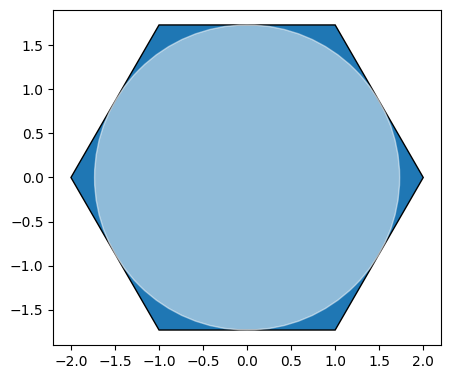

center: ( 0.000 , 0.000 )
radius: 1.732


In [24]:
if __name__ == '__main__':
    # test
    points = [[2.0, 0.0], [1.0, 1.732],[-1.0,1.732],[-2.0,0],[-1.0,-1.732],[1.0,-1.732]]
    
    fig = plt.figure(num=3, figsize=(5, 5))
    axes = fig.add_subplot(1, 1, 1)
    ax = plt.gca()
    ax.set_aspect(1)
    
    plt.autoscale(True)
    p = plt.Polygon(xy=points, edgecolor='black')
    axes.add_patch(p)
    points=np.array(points)
    
    
    center, radius = max_inscribed_circle(points)
    c = Circle(xy=(center[0], center[1]), radius=radius, alpha=0.5, color='white')
    axes.add_patch(c)
    plt.show()
    # print the results, 3 decimal places
    print("center:", "(", '{:.3f}'.format(center[0]),",", '{:.3f}'.format(center[1]),")")
    print("radius:", '{:.3f}'.format(radius))

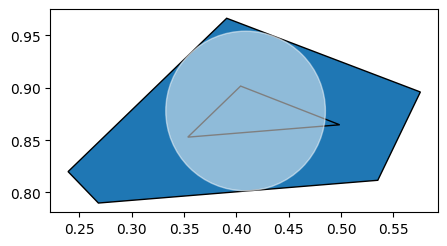

center: ( 0.409 , 0.878 )
radius: 0.076


In [25]:
if __name__ == '__main__':
    # test
    # points = [[0, 0], [2, 0], [2, 1], [0, 3]]
    points = [[0.23920251,0.81987335],[0.268166, 0.78983638], [0.53517593,0.81158025], [0.57586533,0.89596664], [0.39077451,0.96642085]]

    
    fig = plt.figure(num=3, figsize=(5, 5))
    axes = fig.add_subplot(1, 1, 1)
    ax = plt.gca()
    ax.set_aspect(1)
    
    plt.autoscale(True)
    p = plt.Polygon(xy=points, edgecolor='black')
    axes.add_patch(p)
    points=np.array(points)
    
    
    center, radius = max_inscribed_circle(points)
    c = Circle(xy=(center[0], center[1]), radius=radius, alpha=0.5, color='white')
    axes.add_patch(c)
    plt.show()
    # print the results, 3 decimal places
    print("center:", "(", '{:.3f}'.format(center[0]),",", '{:.3f}'.format(center[1]),")")
    print("radius:", '{:.3f}'.format(radius))

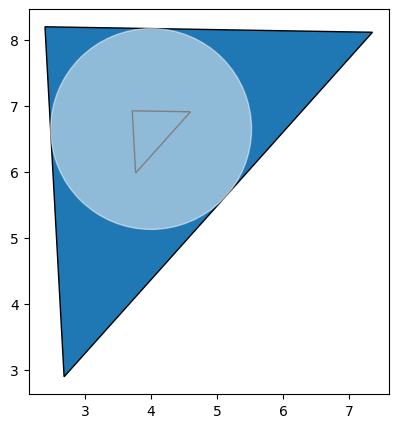

center: ( 4.000 , 6.651 )
radius: 1.521


In [26]:
if __name__ == '__main__':
    # test
    points = [[2.3920251,8.1987335],[2.68166, 2.8983638], [7.3517593,8.1158025]]
    
    fig = plt.figure(num=3, figsize=(5, 5))
    axes = fig.add_subplot(1, 1, 1)
    ax = plt.gca()
    ax.set_aspect(1)
    
    plt.autoscale(True)
    p = plt.Polygon(xy=points, edgecolor='black')
    axes.add_patch(p)
    points=np.array(points)
    
    
    center, radius = max_inscribed_circle(points)
    c = Circle(xy=(center[0], center[1]), radius=radius, alpha=0.5, color='white')
    axes.add_patch(c)
    plt.show()
    # print the results, 3 decimal places
    print("center:", "(", '{:.3f}'.format(center[0]),",", '{:.3f}'.format(center[1]),")")
    print("radius:", '{:.3f}'.format(radius))

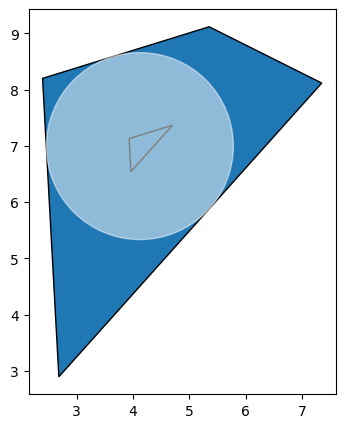

center: ( 4.121 , 6.996 )
radius: 1.661


In [27]:
if __name__ == '__main__':
    # test
    points = [[2.3920251,8.1987335],[2.68166, 2.8983638], [7.3517593,8.1158025], [5.3517593,9.1158025]]
    
    fig = plt.figure(num=3, figsize=(5, 5))
    axes = fig.add_subplot(1, 1, 1)
    ax = plt.gca()
    ax.set_aspect(1)
    
    plt.autoscale(True)
    p = plt.Polygon(xy=points, edgecolor='black')
    axes.add_patch(p)
    points=np.array(points)
    
    
    center, radius = max_inscribed_circle(points)
    c = Circle(xy=(center[0], center[1]), radius=radius, alpha=0.5, color='white')
    axes.add_patch(c)
    plt.show()
    # print the results, 3 decimal places
    print("center:", "(", '{:.3f}'.format(center[0]),",", '{:.3f}'.format(center[1]),")")
    print("radius:", '{:.3f}'.format(radius))